The project is about ....

Dataset is : AI vs Human Text

In [ ]:
import pandas as pd
import csv
df = pd.read_csv('/content/AI_Human.csv', quoting=csv.QUOTE_NONE, on_bad_lines='skip')

print(df.head())

                                                                                                                                                    text  \
"Cars. Cars have been around since they became ... when Henry Ford created and built the first Mod...   people are starting to question if limiting c...   
"""America's love affair with it's vehicles see... it is easier to suggest that America's car usag...   along with a decrease in pollution and depend...   
"The electrol college system is an unfair system   people don't have the right to select their own...   they dont have the right to select a presiden...   
In source two and three it states the rule "" w... winning can take it all                              that vote that they take from the losing does...   
In conclusion                                      the state senators should eliminate the elector...   and don't count other votes that is not popul...   

                                                               

In [ ]:
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['generated_word_count'] = df['generated'].apply(lambda x: len(str(x).split()))

df['text_char_count'] = df['text'].apply(lambda x: len(str(x)))
df['generated_char_count'] = df['generated'].apply(lambda x: len(str(x)))

print(df[['text_word_count', 'generated_word_count', 'text_char_count', 'generated_char_count']].head())

                                                                                                       text_word_count  \
"Cars. Cars have been around since they became ... when Henry Ford created and built the first Mod...               16   
"""America's love affair with it's vehicles see... it is easier to suggest that America's car usag...                8   
"The electrol college system is an unfair system   people don't have the right to select their own...               10   
In source two and three it states the rule "" w... winning can take it all                                          31   
In conclusion                                      the state senators should eliminate the elector...               50   

                                                                                                       generated_word_count  \
"Cars. Cars have been around since they became ... when Henry Ford created and built the first Mod...                    12   
"""America's 

In [ ]:
df['word_difference'] = df['text_word_count'] - df['generated_word_count']
df['char_difference'] = df['text_char_count'] - df['generated_char_count']
print(df[['text', 'generated', 'word_difference', 'char_difference']].head())

                                                                                                                                                    text  \
"Cars. Cars have been around since they became ... when Henry Ford created and built the first Mod...   people are starting to question if limiting c...   
"""America's love affair with it's vehicles see... it is easier to suggest that America's car usag...   along with a decrease in pollution and depend...   
"The electrol college system is an unfair system   people don't have the right to select their own...   they dont have the right to select a presiden...   
In source two and three it states the rule "" w... winning can take it all                              that vote that they take from the losing does...   
In conclusion                                      the state senators should eliminate the elector...   and don't count other votes that is not popul...   

                                                               

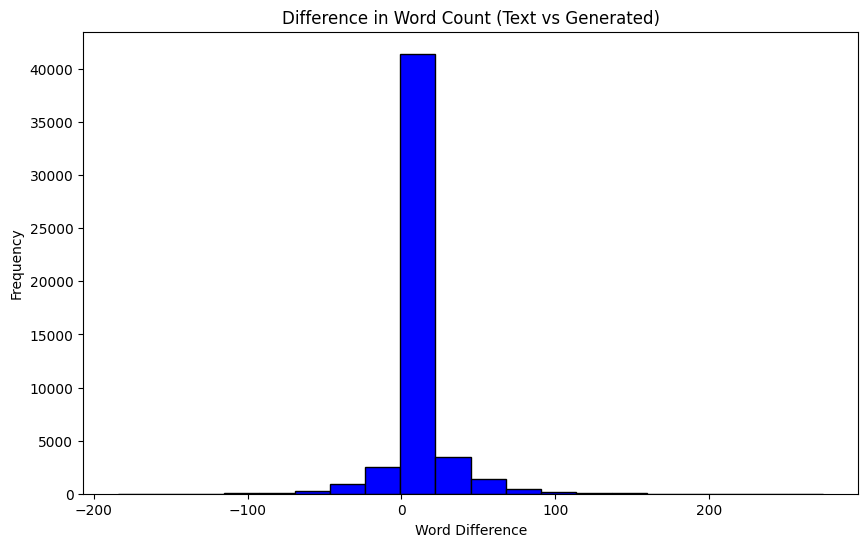

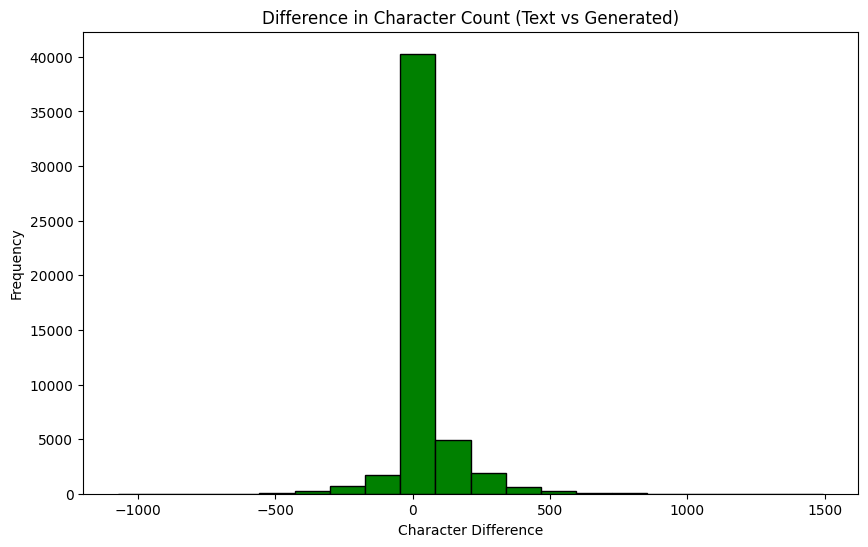

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['word_difference'], bins=20, color='blue', edgecolor='black')
plt.title('Difference in Word Count (Text vs Generated)')
plt.xlabel('Word Difference')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['char_difference'], bins=20, color='green', edgecolor='black')
plt.title('Difference in Character Count (Text vs Generated)')
plt.xlabel('Character Difference')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 0].values.reshape(-1, 1)
y = df.iloc[:, 1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import cudf

data = cudf.read_csv('/content/AI_Human.csv')

print(data.head())

                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0


In [ ]:
X = data['text']

y = data['generated']

In [ ]:
from cuml.feature_extraction.text import TfidfVectorizer
import cupy as cp

vectorizer = TfidfVectorizer()
X_transformed = vectorizer.fit_transform(X)

X_transformed_cp = cp.sparse.csr_matrix(X_transformed)
print(X_transformed_cp.shape)

(487235, 259050)


In [ ]:
import cudf
from cuml.feature_extraction.text import TfidfVectorizer
import cupy as cp

vectorizer = TfidfVectorizer()
X_transformed = vectorizer.fit_transform(X)

X_transformed_cudf = cudf.DataFrame.from_pandas(X_transformed.toarray())

print(X_transformed_cudf.shape)

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /tmp/pip-build-env-c7imy8iv/normal/lib/python3.11/site-packages/librmm/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory

In [ ]:
X_small = X[:100000]
y_small = y[:100000]

In [ ]:
X_small = X[:100000]
y_small = y[:100000]

vectorizer = cuTfidfVectorizer(max_features=2000)
X_transformed = vectorizer.fit_transform(X_small)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
X_transformed = vectorizer.fit_transform(X_small)

In [ ]:

X_small = X[:50000]
y_small = y[:50000]

vectorizer = cuTfidfVectorizer(max_features=1000)
X_transformed = vectorizer.fit_transform(X_small)

In [ ]:
import cudf
import cupy as cp
from cuml.decomposition import TruncatedSVD

X_dense = X_transformed.toarray()

svd = TruncatedSVD(n_components=100)
X_transformed_svd = svd.fit_transform(X_dense)

print(X_transformed_svd.shape)

(50000, 100)


Naive Bayes Accuracy: 0.34101998805999756
Logistic Regression Accuracy: 0.9833400249481201
Random Forest Accuracy: 0.9983400106430054


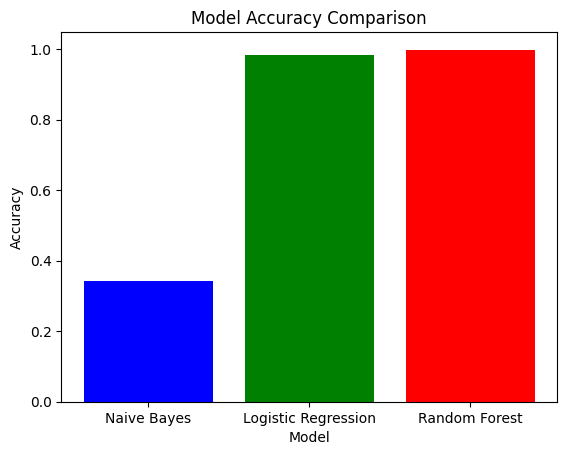

In [ ]:
from cuml.naive_bayes import MultinomialNB
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score
import matplotlib.pyplot as plt

nb_model = MultinomialNB()
nb_model.fit(X_transformed_svd, y_small)

nb_pred = nb_model.predict(X_transformed_svd)
nb_accuracy = accuracy_score(y_small, nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy}")

lr_model = LogisticRegression()
lr_model.fit(X_transformed_svd, y_small)

lr_pred = lr_model.predict(X_transformed_svd)
lr_accuracy = accuracy_score(y_small, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

rf_model = RandomForestClassifier()
rf_model.fit(X_transformed_svd, y_small)

rf_pred = rf_model.predict(X_transformed_svd)
rf_accuracy = accuracy_score(y_small, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy}")

models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']
accuracies = [nb_accuracy, lr_accuracy, rf_accuracy]

plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

In [ ]:
import cupy as cp
import time
from cuml.naive_bayes import MultinomialNB
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score

gpu_before_free, gpu_before_total = cp.cuda.runtime.memGetInfo()

start_time = time.time()
nb_model = MultinomialNB()
nb_model.fit(X_transformed_svd, y_small)
nb_pred = nb_model.predict(X_transformed_svd)
nb_accuracy = accuracy_score(y_small, nb_pred)
end_time = time.time()

gpu_after_free, gpu_after_total = cp.cuda.runtime.memGetInfo()
gpu_memory_used = gpu_after_total - gpu_before_total

print(f"Naive Bayes Training Time: {end_time - start_time} seconds")
print(f"Naive Bayes Memory Used: {gpu_memory_used} bytes")

start_time = time.time()
lr_model = LogisticRegression()
lr_model.fit(X_transformed_svd, y_small)
lr_pred = lr_model.predict(X_transformed_svd)
lr_accuracy = accuracy_score(y_small, lr_pred)
end_time = time.time()

gpu_after_free, gpu_after_total = cp.cuda.runtime.memGetInfo()
gpu_memory_used = gpu_after_total - gpu_before_total

print(f"Logistic Regression Training Time: {end_time - start_time} seconds")
print(f"Logistic Regression Memory Used: {gpu_memory_used} bytes")

start_time = time.time()
rf_model = RandomForestClassifier()
rf_model.fit(X_transformed_svd, y_small)
rf_pred = rf_model.predict(X_transformed_svd)
rf_accuracy = accuracy_score(y_small, rf_pred)
end_time = time.time()

gpu_after_free, gpu_after_total = cp.cuda.runtime.memGetInfo()
gpu_memory_used = gpu_after_total - gpu_before_total

print(f"Random Forest Training Time: {end_time - start_time} seconds")
print(f"Random Forest Memory Used: {gpu_memory_used} bytes")

Naive Bayes Training Time: 0.039766550064086914 seconds
Naive Bayes Memory Used: 0 bytes
Logistic Regression Training Time: 0.16526389122009277 seconds
Logistic Regression Memory Used: 0 bytes
Random Forest Training Time: 2.451378583908081 seconds
Random Forest Memory Used: 0 bytes


In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from cuml.metrics import accuracy_score
import time

dtrain = xgb.DMatrix(X_transformed_svd, label=y_small)
dtest = xgb.DMatrix(X_transformed_svd, label=y_small)

params = {
    'tree_method': 'hist',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}

start_time = time.time()
bst = xgb.train(params, dtrain, num_boost_round=100)

y_pred = bst.predict(dtest)

y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_small, y_pred_binary)
end_time = time.time()

print(f"XGBoost Training Time: {end_time - start_time} seconds")
print(f"XGBoost Accuracy: {accuracy}")

XGBoost Training Time: 1.0968921184539795 seconds
XGBoost Accuracy: 1.0


In [ ]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import numpy as np
dtrain = xgb.DMatrix(X_transformed_svd, label=y_small)

params = {
    'tree_method': 'hist',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}

cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics="logloss", as_pandas=True)

print(cv_results.tail())

cv_accuracy = cv_results['test-logloss-mean'].min()
print(f"XGBoost Cross-Validation Accuracy (Logloss): {cv_accuracy}")

    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
95            0.001615           0.000108           0.028412          0.001818
96            0.001582           0.000106           0.028328          0.001823
97            0.001546           0.000106           0.028280          0.001874
98            0.001511           0.000105           0.028254          0.001913
99            0.001476           0.000098           0.028220          0.001945
XGBoost Cross-Validation Accuracy (Logloss): 0.028220371076160267
